We consider a simple conversion reaction

d/dt A = k1 - k2 * A

where A(0) is known and k1, k2 are to be estimated.


Initially we have one measurement at t=10.

In [1]:
import pypesto.optdesign as optdesign
import pypesto.petab
import pypesto.optimize as optimize
import pypesto.visualize as visualize
import numpy as np
import pandas as pd
import time


In [2]:
importer = pypesto.petab.PetabImporter.from_yaml("conversion_reaction/one_conversion_reaction.yaml")
problem = importer.create_problem()

petab_problem = importer.petab_problem
model=problem.objective.amici_model
obj = problem.objective

optimizer = optimize.ScipyOptimizer()
result = optimize.minimize(problem=problem, optimizer=optimizer, n_starts=10)

In [3]:
# print(result.optimize_result.get_for_key('fval'))
# print(result.optimize_result.as_list(['x'])[0]['x'])

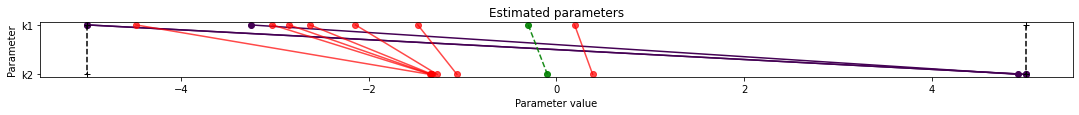

In [4]:
ref = visualize.create_references(
    x=petab_problem.x_nominal_scaled, fval=obj(petab_problem.x_nominal_scaled))

visualize.parameters(result, reference=ref)

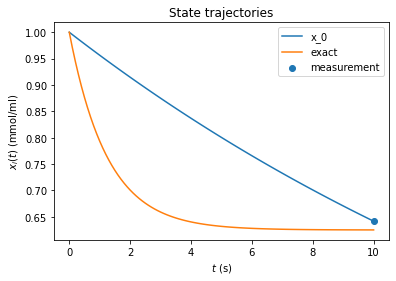

In [5]:
import amici.plotting
model.requireSensitivitiesForAllParameters()
model.setTimepoints(amici.DoubleVector(np.linspace(0, 10, 101)))
model.setParameterScale(amici.ParameterScaling_log10)


temp = result.optimize_result.as_list(['x'])[0]['x']
# these are eg noise parameters for which we have explicit values
missing_params = len(model.getParameterIds()) - len(temp)
for i in range(missing_params):
    temp = np.append(temp, 0)
model.setParameters(temp)

solver = model.getSolver()
solver.setSensitivityMethod(amici.SensitivityMethod_forward)
solver.setSensitivityOrder(amici.SensitivityOrder_first)

# how to run amici now:
rdata = amici.runAmiciSimulation(model, solver, None)
amici.plotting.plotStateTrajectories(rdata)

# correct values
import matplotlib.pyplot as plt
def f(t):
    return (0.625 + 0.375 * np.exp(-0.8*t))
x = np.linspace(0,10,101)
plt.plot(x,f(x), label='exact')
plt.scatter(petab_problem.measurement_df['time'].to_list(),petab_problem.measurement_df['measurement'].to_list(), label='measurement')
plt.legend()

In [6]:
# create list of possible new measurement times to test

n_experiments = 50
experiment_list = []
grid = np.linspace(0,10,n_experiments)
for index, time  in enumerate(grid):
    dict = {'id': index,
            'condition_df': None,
            'observable_df': None,
            'measurement_df': pd.DataFrame([['obs_a', 'c0', time, float('NaN'), 0.02]], 
                                           columns=petab_problem.measurement_df.columns)}
    
    experiment_list.append(dict)

In [7]:
# create problem

design_problem = optdesign.DesignProblem(experiment_list=experiment_list, 
                                         problem=problem,
                                         petab_problem=importer.petab_problem, 
                                         model=problem.objective.amici_model, 
                                         result=result, 
                                         n_save_combi_result=float('inf'))

In [8]:
# Consider the eigenvalues of the initial setting

from pypesto.optdesign.opt_design_helpers import get_design_result

initial = get_design_result(design_problem=design_problem,x=design_problem.initial_x, candidate=None)
#eigvals from initial setting
print(initial['eigvals'])

[1.11022302e-16 1.11889667e+03]


In [9]:
# run experimental design
import time
start_time = time.time()

design_result = optdesign.run_exp_design(design_problem)

print("time elapsed: {:.2f}s".format(time.time() - start_time))

time elapsed: 0.11s


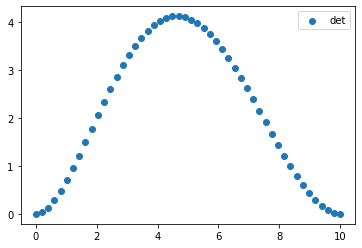

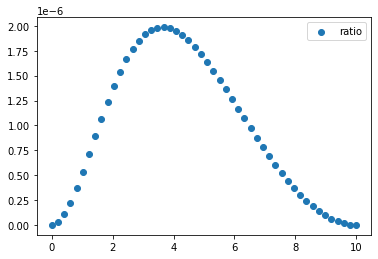

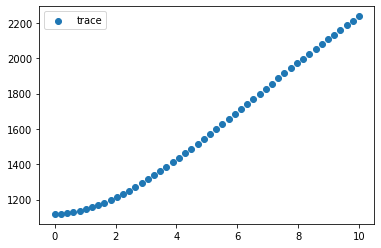

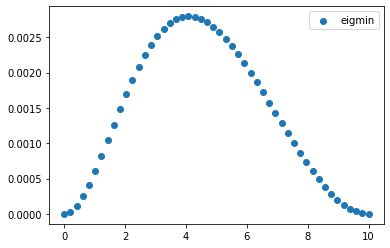

In [10]:
# visualise the criteria values at different time points
import matplotlib.pyplot as plt

plt.scatter(grid, design_result.get_criteria_values('det'), label='det')
plt.legend()
plt.show()
plt.scatter(grid, design_result.get_criteria_values('ratio'), label='ratio')
plt.legend()
plt.show()
plt.scatter(grid, design_result.get_criteria_values('trace'), label='trace')
plt.legend()
plt.show()
plt.scatter(grid, design_result.get_criteria_values('eigmin'), label='eigmin')
plt.legend()
plt.show()
if design_problem.const_for_hess is not None:
    plt.scatter(grid, design_result.get_criteria_values('det_modified'), label='det_modified')
    plt.legend()
    plt.show()
    plt.scatter(grid, design_result.get_criteria_values('ratio_modified'), label='ratio_modified')
    plt.legend()
    plt.show()
    plt.scatter(grid, design_result.get_criteria_values('trace_modified'), label='trace_modified')
    plt.legend()
    plt.show()
    plt.scatter(grid, design_result.get_criteria_values('eigmin_modified'), label='eigmin_modified')
    plt.legend()
    plt.show()

In [11]:
#eigvals after adding different timepoints

# design_result.get_criteria_values('eigvals')

# Add two conditions - full space

In [12]:
start_time2 = time.time()

design_result.check_combinations(list_of_combinations=2)

print("time elapsed: {:.2f}s".format(time.time() - start_time2))

time elapsed: 0.22s


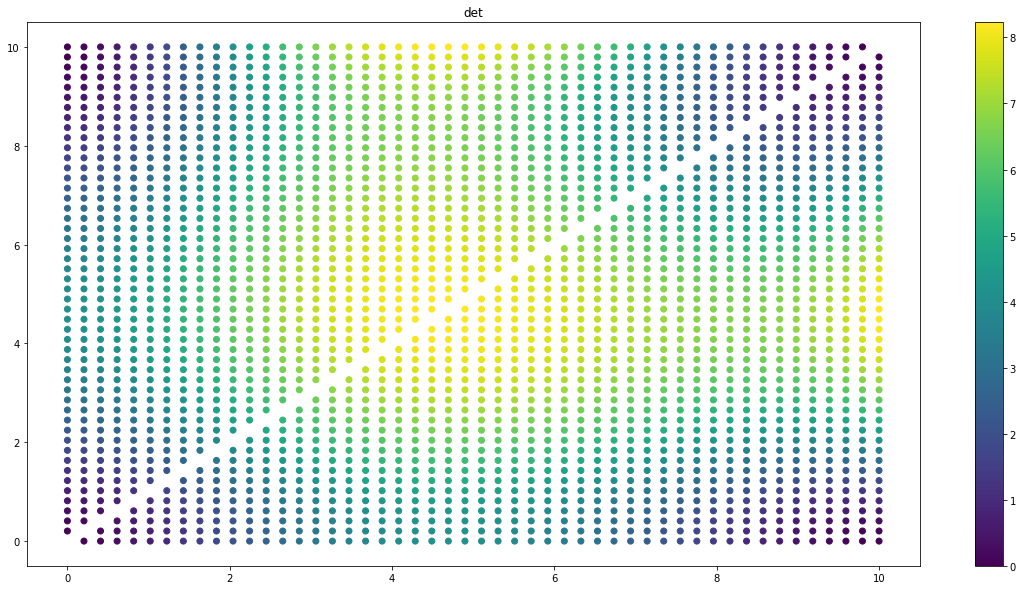

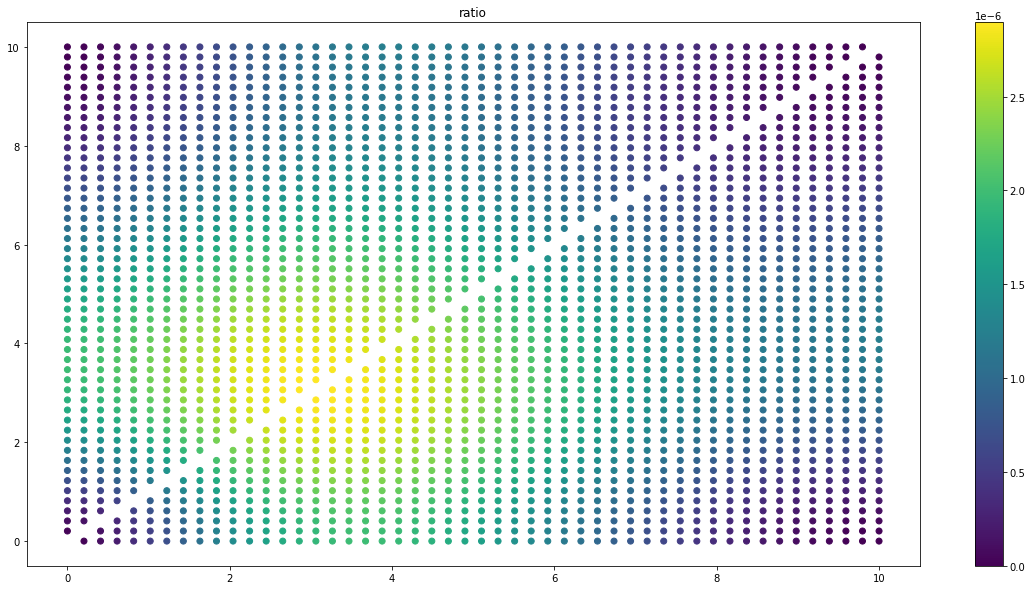

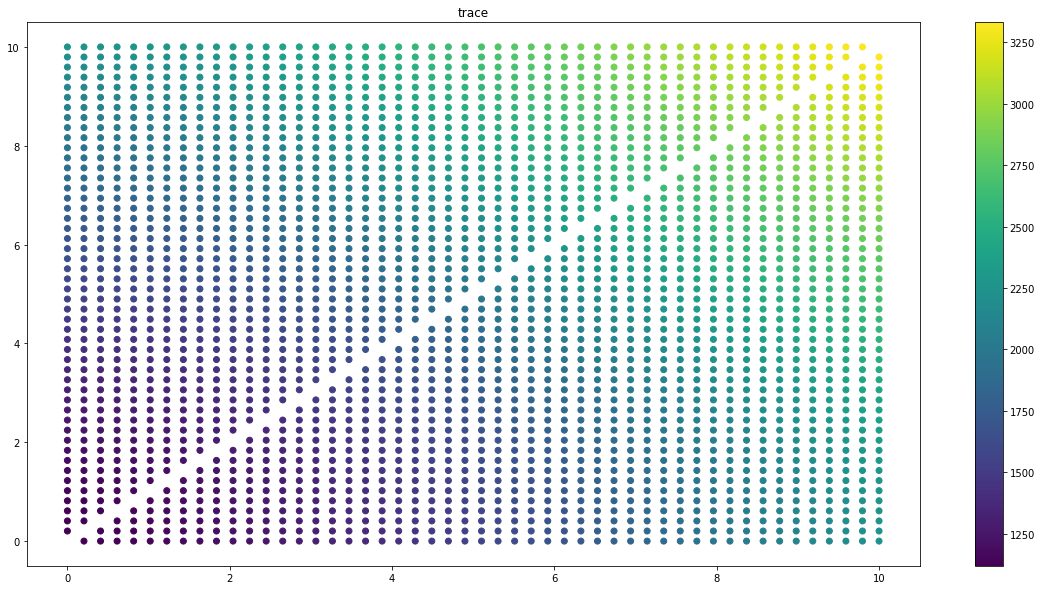

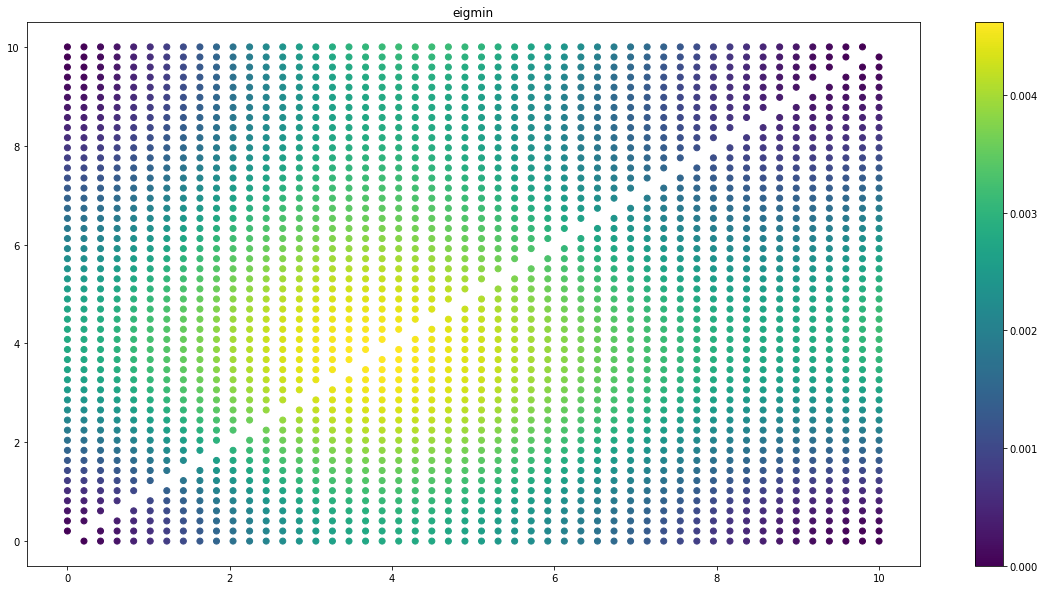

In [13]:
for criteria in ['det', 'ratio', 'trace', 'eigmin']:
    fig = plt.figure(figsize=(20, 10))
    ax = plt.axes()
    
    list_of_indices = design_result.get_best_combi_index(criteria)
    x = list_of_indices[0]
    y = list_of_indices[1]
    index_combis = design_result.list_of_combinations
    z = design_result.get_criteria_values(criteria=criteria, runs='combi_runs')

    heatmap = ax.scatter(grid[x], grid[y], c=z, cmap='viridis', label=criteria)
    heatmap = ax.scatter(grid[y], grid[x], c=z, cmap='viridis', label=criteria)
    plt.colorbar(heatmap)
    plt.title(criteria)
    plt.show()

# Add two conditions - chosen combinations

In [14]:
start_time = time.time()

design_result.check_combinations(list_of_combinations=[[0,1], [1,2], [12,13]])

print("time elapsed: {:.2f}s".format(time.time() - start_time))

time elapsed: 0.00s


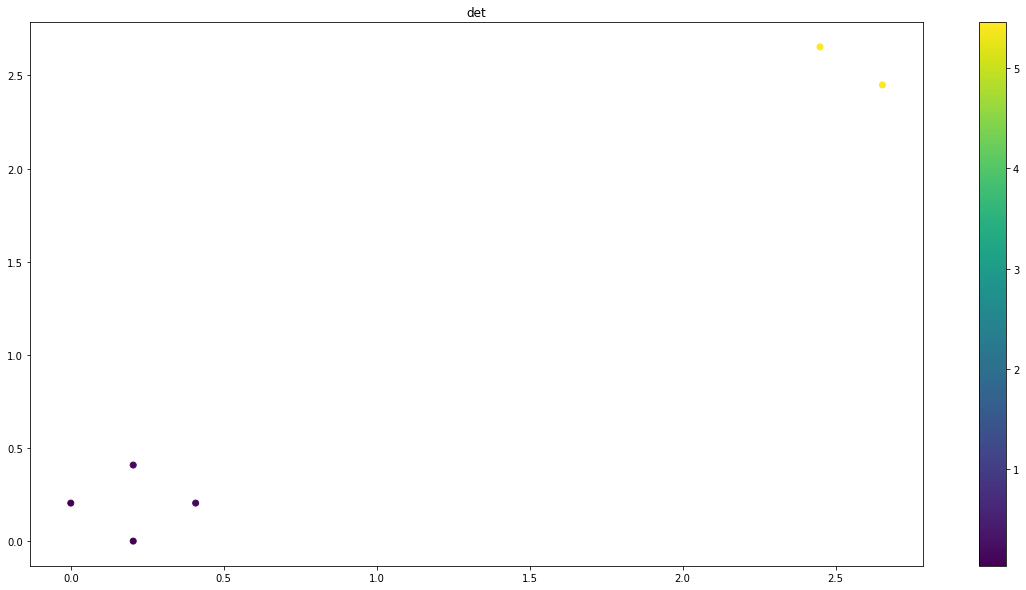

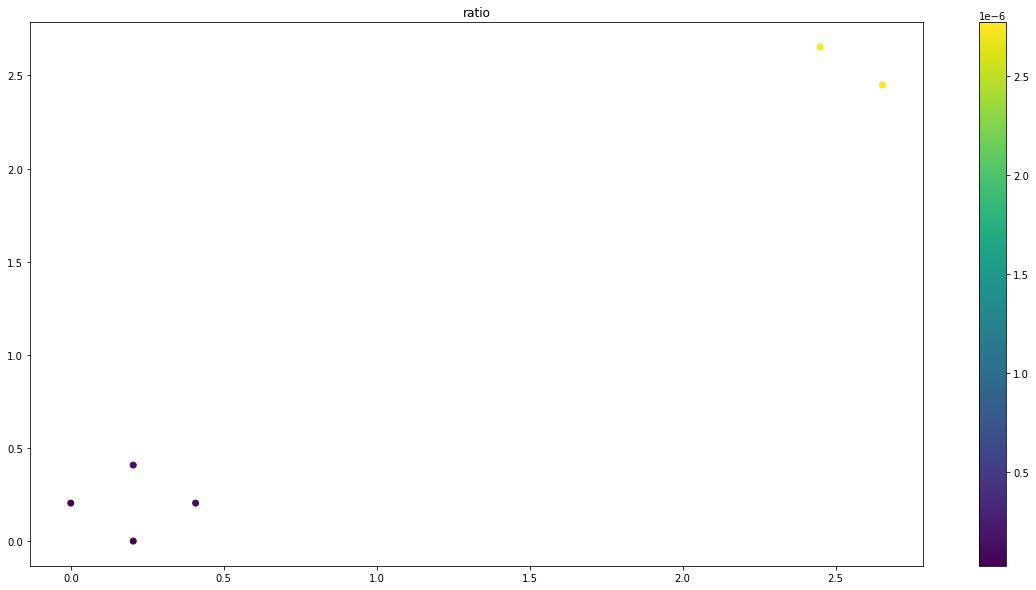

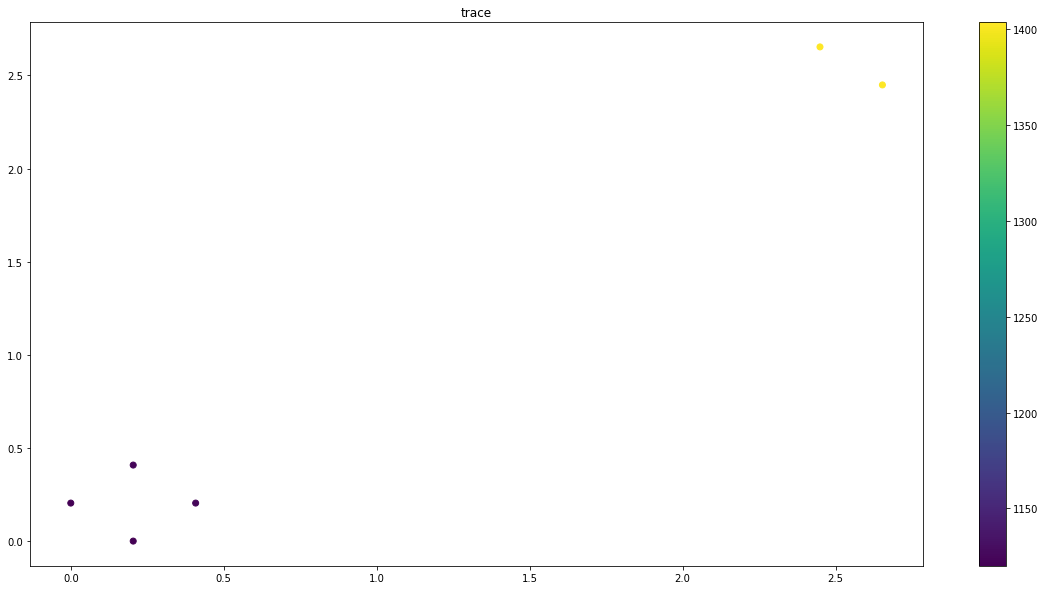

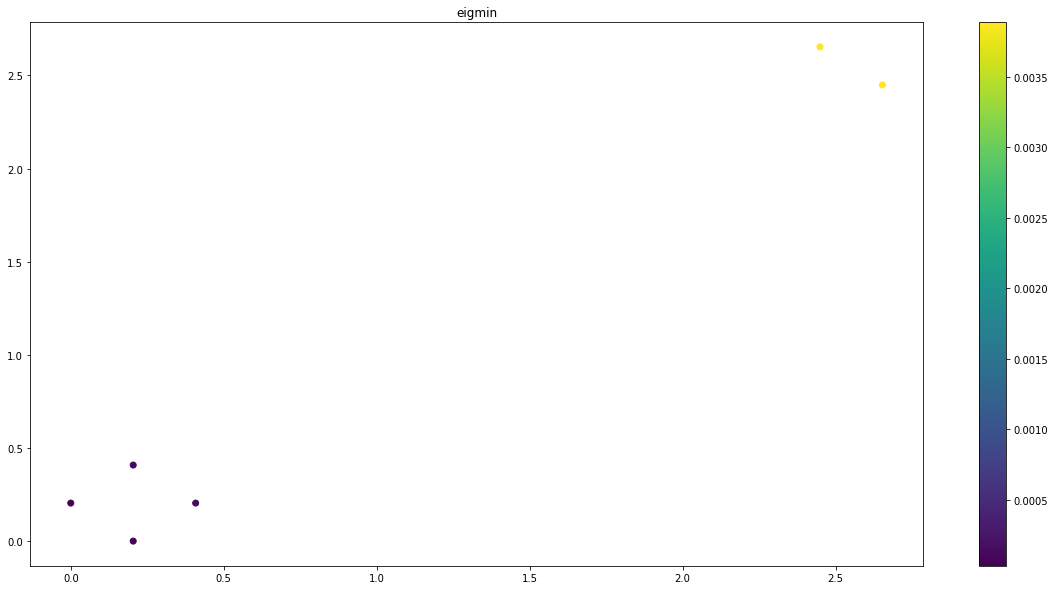

In [15]:
for criteria in ['det', 'ratio', 'trace', 'eigmin']:
    fig = plt.figure(figsize=(20, 10))
    ax = plt.axes()

    list_of_indices = design_result.get_best_combi_index(criteria)
    x = list_of_indices[0]
    y = list_of_indices[1]
    index_combis = design_result.list_of_combinations
    z = design_result.get_criteria_values(criteria=criteria, runs='combi_runs')

    heatmap = ax.scatter(grid[x], grid[y], c=z, cmap='viridis', label=criteria)
    heatmap = ax.scatter(grid[y], grid[x], c=z, cmap='viridis', label=criteria)
    plt.colorbar(heatmap)
    plt.title(criteria)
    plt.show()